In [1]:
%%time

from adlfs import AzureBlobFileSystem

import time

import json
import pandas
import pandas as pd
from tqdm import tqdm

from common.schemas.pyarrow_schema import tagging_schema
from common.storage.azure_file_storage import AzureFileStorageAdapter
from common.captioning.azure_descriptions import AzureCaption
from common.schemas.pyarrow_schema import schema

tqdm.pandas(desc="Progress")
file_system: AzureBlobFileSystem = AzureFileStorageAdapter('data').get_file_storage()

from common.data_frame_functions.functions import Functions

functions: Functions = Functions()

caption: AzureCaption = AzureCaption(file_system)

CPU times: total: 9.81 s
Wall time: 13.7 s


In [30]:
%%time

curated_df = pandas.read_parquet('data/parquet/back.parquet', filesystem=file_system, engine='pyarrow')

CPU times: total: 734 ms
Wall time: 1.82 s


In [2]:
%%time

captions = pd.read_parquet('data/parquet/image_captions.parquet', filesystem=file_system, engine='pyarrow')
tags = pd.read_parquet('data/parquet/image_tags.parquet', filesystem=file_system, engine='pyarrow')
crops = pd.read_parquet('data/parquet/image_cropping.parquet', filesystem=file_system, engine='pyarrow')

display(captions.shape)
display(tags.shape)
display(crops.shape)

(16720, 7)

(38085, 3)

(1872, 6)

CPU times: total: 312 ms
Wall time: 2.73 s


In [3]:
%%time

current_captions = file_system.ls("data/caption")
display(len(current_captions))

3509

CPU times: total: 5.19 s
Wall time: 7.64 s


In [23]:
%%time

all_data = []
for caption_file in tqdm(current_captions, total=len(current_captions), desc='Reading caption files'):
	caption_data = json.loads(file_system.read_text(caption_file, encoding='utf-8'))
	dense_caption_result = caption_data.get('denseCaptionsResult')
	metadata = caption_data.get('metadata')
	tags_result = caption_data.get('tagsResult')
	smart_crop_result = caption_data.get('smartCropsResult')
	basic_caption = caption_data.get('captionResult')
	image_id = caption_file.split('/')[-1].split('.')[0]
	filtered_data = {
		"id": image_id,
		'captions': [basic_caption],
		"dense_captions": dense_caption_result['values'],
		"meta": [metadata],
		"tags": tags_result['values'],
		"smart_crop": smart_crop_result['values']
	}
	all_data.append(filtered_data)

Reading caption files: 100%|██████████| 3509/3509 [04:40<00:00, 12.52it/s]

CPU times: total: 1min 27s
Wall time: 4min 40s


In [24]:
%%time

new_captions = pandas.json_normalize(data=all_data, record_path=['dense_captions'], meta=['id'], record_prefix='dense_captions_')
new_tags = pandas.json_normalize(data=all_data, record_path=['tags'], meta=['id'], record_prefix='tags_')
new_crops = pandas.json_normalize(data=all_data, record_path=['smart_crop'], meta=['id'], record_prefix='smart_crop_')

CPU times: total: 4.28 s
Wall time: 5.61 s


In [25]:
%%time

new_basic_captions = pandas.json_normalize(data=all_data, record_path=['captions'], meta=['id'], record_prefix='captions_')
meta = pandas.json_normalize(data=all_data, record_path=['meta'], meta=['id'], record_prefix='meta_')

CPU times: total: 266 ms
Wall time: 395 ms


In [26]:
%%time

display(new_captions)
display(new_tags)
display(new_crops)
display(new_basic_captions)
display(meta)

,dense_captions_text,dense_captions_confidence,dense_captions_boundingBox.x,dense_captions_boundingBox.y,dense_captions_boundingBox.w,dense_captions_boundingBox.h,id
0,a woman taking a selfie,0.662057,0,0,1468,2608,1002cx2
1,a woman taking a selfie,0.665344,0,100,1447,2473,1002cx2
2,a woman wearing a black dress,0.473444,185,1443,1265,1150,1002cx2
3,a close up of a key,0.593095,716,1503,82,140,1002cx2
4,a close up of an eye,0.619898,778,744,152,84,1002cx2
...,...,...,...,...,...,...,...
31175,a close-up of a green plant,0.453059,680,1066,394,280,zzxq2l
31176,a mountain range in the distance,0.334624,498,277,568,99,zzxq2l
31177,a woman smiling at the camera,0.465720,244,293,319,530,zzxq2l
31178,a woman wearing a dress,0.548892,0,758,1048,570,zzxq2l


,tags_name,tags_confidence,id
0,person,0.998358,1002cx2
1,human face,0.997763,1002cx2
2,clothing,0.990993,1002cx2
3,lady,0.981919,1002cx2
4,smile,0.964994,1002cx2
...,...,...,...
71148,woman,0.753262,zzxq2l
71149,beach,0.739799,zzxq2l
71150,standing,0.630927,zzxq2l
71151,girl,0.556561,zzxq2l


,smart_crop_aspectRatio,smart_crop_boundingBox.x,smart_crop_boundingBox.y,smart_crop_boundingBox.w,smart_crop_boundingBox.h,id
0,1.0,0,140,1462,1462,1002cx2
1,1.0,143,138,1249,1250,1003dod
2,1.0,0,355,1948,1948,1008ddt
3,1.0,0,224,1120,1120,100dcrd
4,1.0,0,0,1107,1107,100jl1b
...,...,...,...,...,...,...
3504,1.0,0,0,1025,1025,zzr9nz
3505,1.0,0,0,461,461,zzruf4
3506,1.0,0,0,2273,2273,zzu8i8
3507,1.0,135,0,1299,1299,zzvv3x


,captions_text,captions_confidence,id
0,a woman taking a selfie,0.662057,1002cx2
1,a woman in a garment standing next to a tree,0.513081,1003dod
2,a woman taking a selfie,0.658102,1008ddt
3,a group of women posing for a picture,0.556227,100dcrd
4,a group of women posing for a picture,0.614969,100jl1b
...,...,...,...
3504,two women in garments on a beach,0.529292,zzr9nz
3505,a woman with tattoos on her arm,0.501798,zzruf4
3506,a woman in a blue lingerie,0.430763,zzu8i8
3507,a woman sitting on a bed,0.584322,zzvv3x


,meta_width,meta_height,id
0,1468,2608,1002cx2
1,1523,2030,1003dod
2,1956,3075,1008ddt
3,1152,1642,100dcrd
4,1152,1152,100jl1b
...,...,...,...
3504,1080,1350,zzr9nz
3505,570,704,zzruf4
3506,2309,2560,zzu8i8
3507,1440,1800,zzvv3x


CPU times: total: 141 ms
Wall time: 111 ms


In [31]:
merge_singles = pandas.merge(new_basic_captions, meta, on='id').set_index(keys=['id'], drop=False)
merge_singles.drop_duplicates(inplace=True)
merge_singles.reset_index(drop=True, inplace=True)
display(merge_singles)

,captions_text,captions_confidence,id,meta_width,meta_height
0,a woman taking a selfie,0.662057,1002cx2,1468,2608
1,a woman in a garment standing next to a tree,0.513081,1003dod,1523,2030
2,a woman taking a selfie,0.658102,1008ddt,1956,3075
3,a group of women posing for a picture,0.556227,100dcrd,1152,1642
4,a group of women posing for a picture,0.614969,100jl1b,1152,1152
...,...,...,...,...,...
3504,two women in garments on a beach,0.529292,zzr9nz,1080,1350
3505,a woman with tattoos on her arm,0.501798,zzruf4,570,704
3506,a woman in a blue lingerie,0.430763,zzu8i8,2309,2560
3507,a woman sitting on a bed,0.584322,zzvv3x,1440,1800


In [35]:
merged_to_curate = pandas.merge(merge_singles, curated_df, on='id', how='outer').set_index(keys=['id'], drop=False)
merged_to_curate.fillna(value='', inplace=True)
display(merged_to_curate)

,captions_text,captions_confidence,id,meta_width,meta_height,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,model,exists,curated,accept,tags
id,,,,,,,,,,,,,,,,,,,
1002cx2,a woman taking a selfie,0.662057,1002cx2,1468.0,2608.0,SFWRedheads,Sayleywayley,Happy New Year to every single person near and...,blonde woman with red hair and black bra top p...,1fb785ca16b10f4f7613961f0b88f369,/r/SFWRedheads/comments/1002cx2/happy_new_year...,https://i.redd.it/el3s490lzb9a1.jpg,1002cx2.jpg,data/image/1002cx2.jpg,RedHeadDiffusion,True,True,True,[]
1003dod,a woman in a garment standing next to a tree,0.513081,1003dod,1523.0,2030.0,HotGirlNextDoor,fairytale808,pink and blonde (iktr),blonde woman in pink bikinisuit standing on a ...,0849c7aafe126ad27b58cb6e6c9c6592,/r/HotGirlNextDoor/comments/1003dod/pink_and_b...,https://i.redd.it/x56eekrd8c9a1.jpg,1003dod.jpg,data/image/1003dod.jpg,SexyDiffusion,True,True,True,[]
1008ddt,a woman taking a selfie,0.658102,1008ddt,1956.0,3075.0,SFWRedheads,Fit_Advertising4668,happy new year from Scotland 🏴󠁧󠁢󠁳󠁣󠁴󠁿,smiling woman in a green velvet dress with a g...,945b3f444ccaa79f73655fa44bd6a156,/r/SFWRedheads/comments/1008ddt/happy_new_year...,https://i.redd.it/rdywcwiyhd9a1.jpg,1008ddt.jpg,data/image/1008ddt.jpg,RedHeadDiffusion,True,True,True,[]
100dcrd,a group of women posing for a picture,0.556227,100dcrd,1152.0,1642.0,HotGirlNextDoor,angizni,College hotties (iktr),three girls in bikinis posing for a picture wi...,f07022ea6fac84354178a09e92dc3865,/r/HotGirlNextDoor/comments/100dcrd/college_ho...,https://i.redd.it/bm6jpns80f9a1.jpg,100dcrd.jpg,data/image/100dcrd.jpg,SexyDiffusion,True,True,True,[]
100jl1b,a group of women posing for a picture,0.614969,100jl1b,1152.0,1152.0,HotGirlNextDoor,angizni,Sorority hotties (iktr),three women in red dresses standing next to ea...,6cdfb6741d444b243542ae7d40f57b40,/r/HotGirlNextDoor/comments/100jl1b/sorority_h...,https://i.redd.it/wfxx3uc35h9a1.jpg,100jl1b.jpg,data/image/100jl1b.jpg,SexyDiffusion,True,True,True,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13d2hsf,,,13d2hsf,,,bathandbodyworks,alesieoksap,Ice Cream Shop Collection?,someone holding a cup of ice cream in their hand,c6788074138175c661fc652bd7630e33,/r/bathandbodyworks/comments/13d2hsf/ice_cream...,https://i.redd.it/uhwamoq99wya1.jpg,13d2hsf.jpg,data/image/13d2hsf.jpg,CandleDiffusion,True,True,True,[]
13d661b,,,13d661b,,,bathandbodyworks,xeloux,Facebook market finds!,three candles are sitting on a blanket on a bed,e868289445c195815dd67dd0df1a65cb,/r/bathandbodyworks/comments/13d661b/facebook_...,https://i.redd.it/skd10hefxwya1.jpg,13d661b.jpg,data/image/13d661b.jpg,CandleDiffusion,True,True,True,[]
13d8s0i,,,13d8s0i,,,bathandbodyworks,Alternative-Tea-9355,Black Cherry Merlot dupe,someone holding a tube of body cream in a store,965bc5a58a597192700234729758101b,/r/bathandbodyworks/comments/13d8s0i/black_che...,https://i.redd.it/xt7qew9qexya1.jpg,13d8s0i.jpg,data/image/13d8s0i.jpg,CandleDiffusion,True,True,False,[]


In [36]:
%%time

merged_captions = pandas.concat([new_captions, captions])
merged_captions.set_index(keys=['id', 'dense_captions_text', 'dense_captions_confidence'], inplace=True, drop=False)
merged_captions.drop_duplicates(inplace=True)
merged_captions.reset_index(drop=True, inplace=True)

display(f'{merged_captions.shape[0] - captions.shape[0]} new rows added to captions')

merged_captions.to_parquet('data/parquet/image_captions.parquet', filesystem=file_system, engine='pyarrow')
display(pandas.read_parquet('data/parquet/image_captions.parquet', filesystem=file_system, engine='pyarrow'))

'14460 new rows added to captions'

,dense_captions_text,dense_captions_confidence,dense_captions_boundingBox.x,dense_captions_boundingBox.y,dense_captions_boundingBox.w,dense_captions_boundingBox.h,id
0,a woman taking a selfie,0.662057,0,0,1468,2608,1002cx2
1,a woman taking a selfie,0.665344,0,100,1447,2473,1002cx2
2,a woman wearing a black dress,0.473444,185,1443,1265,1150,1002cx2
3,a close up of a key,0.593095,716,1503,82,140,1002cx2
4,a close up of an eye,0.619898,778,744,152,84,1002cx2
...,...,...,...,...,...,...,...
31175,a close-up of a green plant,0.453059,680,1066,394,280,zzxq2l
31176,a mountain range in the distance,0.334624,498,277,568,99,zzxq2l
31177,a woman smiling at the camera,0.465720,244,293,319,530,zzxq2l
31178,a woman wearing a dress,0.548892,0,758,1048,570,zzxq2l


CPU times: total: 578 ms
Wall time: 1.86 s


In [37]:
%%time

merged_tags = pandas.concat([new_tags, tags])
merged_tags.set_index(keys=['id', 'tags_name', 'tags_confidence'], inplace=True, drop=False)
merged_tags.drop_duplicates(inplace=True)
merged_tags.reset_index(drop=True, inplace=True)

display(f'{merged_tags.shape[0] - tags.shape[0]} new rows added to tags')

merged_tags.to_parquet('data/parquet/image_tags.parquet', filesystem=file_system, engine='pyarrow')
display(pandas.read_parquet('data/parquet/image_tags.parquet', filesystem=file_system, engine='pyarrow'))

'33068 new rows added to tags'

,tags_name,tags_confidence,id
0,person,0.998358,1002cx2
1,human face,0.997763,1002cx2
2,clothing,0.990993,1002cx2
3,lady,0.981919,1002cx2
4,smile,0.964994,1002cx2
...,...,...,...
71148,woman,0.753262,zzxq2l
71149,beach,0.739799,zzxq2l
71150,standing,0.630927,zzxq2l
71151,girl,0.556561,zzxq2l


CPU times: total: 688 ms
Wall time: 1.5 s


In [38]:
%%time

merged_crops = pandas.concat([new_crops, crops])
merged_crops.set_index(keys=['id'], inplace=True, drop=False)
merged_crops.drop_duplicates(inplace=True)
merged_crops.reset_index(drop=True, inplace=True)

display(f'{merged_crops.shape[0] - crops.shape[0]} new rows added to crops')

merged_crops.to_parquet('data/parquet/image_cropping.parquet', filesystem=file_system, engine='pyarrow')

display(pandas.read_parquet('data/parquet/image_cropping.parquet', filesystem=file_system, engine='pyarrow'))

'1637 new rows added to crops'

,smart_crop_aspectRatio,smart_crop_boundingBox.x,smart_crop_boundingBox.y,smart_crop_boundingBox.w,smart_crop_boundingBox.h,id
0,1.0,0,140,1462,1462,1002cx2
1,1.0,143,138,1249,1250,1003dod
2,1.0,0,355,1948,1948,1008ddt
3,1.0,0,224,1120,1120,100dcrd
4,1.0,0,0,1107,1107,100jl1b
...,...,...,...,...,...,...
3504,1.0,0,0,1025,1025,zzr9nz
3505,1.0,0,0,461,461,zzruf4
3506,1.0,0,0,2273,2273,zzu8i8
3507,1.0,135,0,1299,1299,zzvv3x


CPU times: total: 297 ms
Wall time: 553 ms


,smart_crop_aspectRatio,smart_crop_boundingBox.x,smart_crop_boundingBox.y,smart_crop_boundingBox.w,smart_crop_boundingBox.h,id
0,1.0,0,140,1462,1462,1002cx2


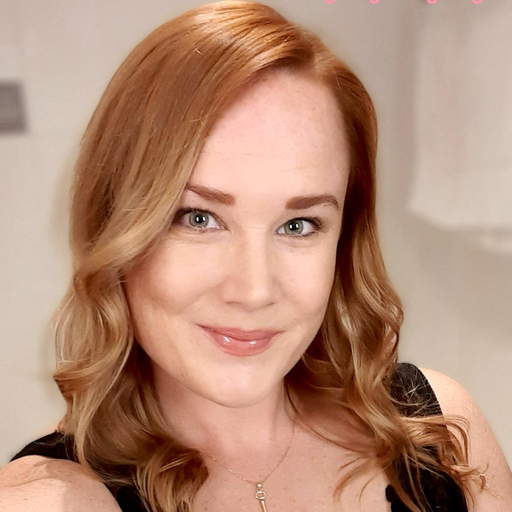

In [74]:
from PIL import Image
import requests

record = curated_df.loc[curated_df['id'] == '1002cx2']
cropping = crops.loc[crops['id'] == '1002cx2']
image_url = file_system.url(record.path.values[0])
display(cropping)
fh = Image.open(requests.get(image_url, stream=True).raw)
copy = fh.copy()
fh.close()
cropped = copy.crop((cropping['smart_crop_boundingBox.x'].values[0], cropping['smart_crop_boundingBox.y'].values[0], cropping['smart_crop_boundingBox.x'].values[0] + cropping['smart_crop_boundingBox.w'].values[0], cropping['smart_crop_boundingBox.y'].values[0] + cropping['smart_crop_boundingBox.h'].values[0]))
resized = cropped.resize((512, 512), 1)
copy.close()
